# Processing DepMap Data

The cancer dependency map profiled cell viability in A549 using an orthogonal assay.
Ultimately, I will determine if the viability predictions are correlated with the observed viability effects.

Here, I process the DepMap viability data to prepare for analysis input.

## Calculating Viability in DepMap

The text below was taken directly from the Cancer Dependency Map README file `primary-screen-readme.txt`.
See [`data/`](data/) for more licensing details.

```
The primary PRISM Repurposing dataset contains the results of pooled-cell line chemical-perturbation viability screens for 4,518 compounds screened against 578 or 562 cell lines. It was processed using the following steps:

- Calculate the median fluorescence intensity (MFI) of each bead-replicate pair.
- Remove outlier-pools. MFI values are log-transformed and centered to the median logMFI for each cell line on each detection plate. For each well on a plate, the median of the centered values is standardized (using median and MAD) against all other wells in the same position in the same screen. Data from wells with a standardized score greater than 5 or less than -5 is filtered.
- Remove cell line-plates with low control separation. For each cell line-detection plate combination, the SSMD is calculated between the logMFI of positive and negative control treatments. Cell line-detection plates with an SSMD > -2 are removed.
- Divide data from each well-detection plate by the median of control barcodes from the same well-detection plate.
- Calculate log2-fold-change for data relative to negative-control wells from the same cell line on the same detection plate.
- Positive-control and negative-control treatments are removed.
- Run ComBat for each treatment condition (compound plate-well combination), considering log-viability values as probes and cell line pool-replicate combinations as batches.
- Median-collapse each drug-dose-cell line combination
```

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
def recode_dose(x, doses, return_level=False):
    closest_index = np.argmin([np.abs(dose - x) for dose in doses])
    if np.isnan(x):
        return 0
    if return_level:
        return closest_index + 1
    else:
        return doses[closest_index]

In [3]:
data_dir = "data"
cell_line_id = "A549_LUNG"
primary_dose_mapping = [0.04, 0.12, 0.37, 1.11, 3.33, 10, 20]

## Load Cell Line Information

In [4]:
cell_file = os.path.join(data_dir, "primary-screen-cell-line-info.csv")
cell_df = pd.read_csv(cell_file, index_col=0)

print(cell_df.shape)
cell_df.head()

(588, 9)


,depmap_id,ccle_name,primary_tissue,secondary_tissue,tertiary_tissue,passed_str_profiling,str_profiling_notes,originally_assigned_depmap_id,originally_assigned_ccle_name
row_name,,,,,,,,,
ACH-000824,ACH-000824,KYSE510_OESOPHAGUS,esophagus,esophagus_squamous,NaN,True,NaN,NaN,NaN
ACH-000954,ACH-000954,HEC1A_ENDOMETRIUM,uterus,uterus_endometrium,NaN,True,NaN,NaN,NaN
ACH-000601,ACH-000601,MIAPACA2_PANCREAS,pancreas,NaN,NaN,True,NaN,NaN,NaN
ACH-000651,ACH-000651,SW620_LARGE_INTESTINE,colorectal,NaN,NaN,True,NaN,NaN,NaN
ACH-000361,ACH-000361,SKHEP1_LIVER,liver,NaN,NaN,True,NaN,NaN,NaN


In [5]:
cell_df = cell_df.query("ccle_name == @cell_line_id")
cell_df

,depmap_id,ccle_name,primary_tissue,secondary_tissue,tertiary_tissue,passed_str_profiling,str_profiling_notes,originally_assigned_depmap_id,originally_assigned_ccle_name
row_name,,,,,,,,,
ACH-000681,ACH-000681,A549_LUNG,lung,lung_NSC,lung_adenocarcinoma,True,NaN,NaN,NaN


In [6]:
depmap_id = cell_df.depmap_id.values[0]
depmap_id

'ACH-000681'

## Load Treatment Information

In [7]:
primary_treatment_file = os.path.join(data_dir, "primary-screen-replicate-collapsed-treatment-info.csv")
primary_treatment_df = pd.read_csv(primary_treatment_file)

print(primary_treatment_df.shape)
primary_treatment_df.head(2)

(4686, 11)


,column_name,broad_id,name,dose,screen_id,moa,target,disease.area,indication,smiles,phase
0,BRD-A00055058-001-01-0::2.325889319::MTS004,BRD-A00055058-001-01-0,RS-0481,2.325889,MTS004,immunostimulant,NaN,NaN,NaN,CC(NC(=O)C1CSCN1C(=O)c1ccccc1)c1ccccc1,Phase 2
1,BRD-A00842753-001-01-9::2.5::MTS004,BRD-A00842753-001-01-9,oleuropein,2.500000,MTS004,estrogen receptor agonist,GPER1,NaN,NaN,COC(=O)C1=COC(OC2OC(CO)C(O)C(O)C2O)\C(=C/C)C1C...,Phase 2


In [8]:
secondary_treatment_file = os.path.join(data_dir, "secondary-screen-replicate-collapsed-treatment-info.csv")
secondary_treatment_df = pd.read_csv(secondary_treatment_file).drop("compound_plate", axis="columns")

print(secondary_treatment_df.shape)
secondary_treatment_df.head(2)

(13008, 11)


,column_name,broad_id,dose,screen_id,name,moa,target,disease.area,indication,smiles,phase
0,BRD-A25234499-001-19-1::0.00061::MTS010::PROS0...,BRD-A25234499-001-19-1,0.00061,MTS010,aminoglutethimide,glucocorticoid receptor antagonist,"CYP11A1, CYP19A1","endocrinology, oncology","Cushing's syndrome, breast cancer","CCC1(CCC(=O)NC1=O)c1ccc(N)cc1, CCC1(CCC(=O)NC1...",Launched
1,BRD-A25234499-001-19-1::0.00244::MTS010::PROS0...,BRD-A25234499-001-19-1,0.00244,MTS010,aminoglutethimide,glucocorticoid receptor antagonist,"CYP11A1, CYP19A1","endocrinology, oncology","Cushing's syndrome, breast cancer","CCC1(CCC(=O)NC1=O)c1ccc(N)cc1, CCC1(CCC(=O)NC1...",Launched


In [9]:
treatment_df = pd.concat([primary_treatment_df, secondary_treatment_df], axis="rows", sort=True)

print(treatment_df.shape)
treatment_df.head(2)

(17694, 11)


,broad_id,column_name,disease.area,dose,indication,moa,name,phase,screen_id,smiles,target
0,BRD-A00055058-001-01-0,BRD-A00055058-001-01-0::2.325889319::MTS004,NaN,2.325889,NaN,immunostimulant,RS-0481,Phase 2,MTS004,CC(NC(=O)C1CSCN1C(=O)c1ccccc1)c1ccccc1,NaN
1,BRD-A00842753-001-01-9,BRD-A00842753-001-01-9::2.5::MTS004,NaN,2.500000,NaN,estrogen receptor agonist,oleuropein,Phase 2,MTS004,COC(=O)C1=COC(OC2OC(CO)C(O)C(O)C2O)\C(=C/C)C1C...,GPER1


## Load Viability Estimates

In [10]:
primary_viability_file = os.path.join(data_dir, "primary-screen-replicate-collapsed-logfold-change.csv")
primary_viability_df = pd.read_csv(primary_viability_file, index_col=0)

print(primary_viability_df.shape)
primary_viability_df.head(2)

(578, 4686)


,BRD-A00077618-236-07-6::2.5::HTS,BRD-A00100033-001-08-9::2.5::HTS,BRD-A00147595-001-01-5::2.5::HTS,BRD-A00218260-001-03-4::2.5::HTS,BRD-A00376169-001-01-6::2.5::HTS,BRD-A00520476-001-07-4::2.5::HTS,BRD-A00546892-001-02-6::2.5::HTS,BRD-A00578795-001-04-3::2.5::HTS,BRD-A00758722-001-04-9::2.5::HTS,BRD-A00827783-001-24-6::2.5::HTS,...,BRD-K98557884-001-01-6::2.5::MTS004,BRD-K99077012-001-01-9::2.332734192::MTS004,BRD-K99199077-001-16-1::2.603211317::MTS004,BRD-K99431849-001-01-7::2.500018158::MTS004,BRD-K99447003-335-04-1::2.37737659::MTS004,BRD-K99506538-001-03-8::2.5::MTS004,BRD-K99616396-001-05-1::2.499991421::MTS004,BRD-K99879819-001-02-1::2.5187366::MTS004,BRD-K99919177-001-01-3::2.5::MTS004,BRD-M63173034-001-03-6::2.64076472::MTS004
ACH-000001,-0.015577,-0.449332,0.489379,0.206675,0.272730,0.021036,-0.025460,0.467158,-0.736306,0.644137,...,0.429238,0.204841,0.150055,-0.575404,-0.101247,0.399233,-0.127658,-0.141651,-1.153652,0.510464
ACH-000007,-0.095730,0.257943,0.772349,-0.438502,-0.732832,0.779201,0.426523,-1.288508,-0.476133,-0.277105,...,-0.471486,0.212998,-0.123230,0.625527,0.383198,0.212031,0.349225,-0.387439,-0.831461,0.323558


In [11]:
secondary_viability_file = os.path.join(data_dir, "secondary-screen-replicate-collapsed-logfold-change.csv")
secondary_viability_df = pd.read_csv(secondary_viability_file, index_col=0)

print(secondary_viability_df.shape)
secondary_viability_df.head(2)

(489, 13008)


,BRD-A00077618-236-07-6::0.00061034::HTS002,BRD-A00077618-236-07-6::0.0024414::HTS002,BRD-A00077618-236-07-6::0.00976562::HTS002,BRD-A00077618-236-07-6::0.0390625::HTS002,BRD-A00077618-236-07-6::0.15625::HTS002,BRD-A00077618-236-07-6::0.625::HTS002,BRD-A00077618-236-07-6::10::HTS002,BRD-A00077618-236-07-6::2.5::HTS002,BRD-A00758722-001-04-9::0.00061034::HTS002,BRD-A00758722-001-04-9::0.0024414::HTS002,...,BRD-U25960968-000-01-9::10::HTS002,BRD-U25960968-000-01-9::2.5::HTS002,BRD-U45393375-000-01-6::0.000610351569230769::HTS002,BRD-U45393375-000-01-6::0.00244140624615385::HTS002,BRD-U45393375-000-01-6::0.009765625::HTS002,BRD-U45393375-000-01-6::0.0390625::HTS002,BRD-U45393375-000-01-6::0.15625::HTS002,BRD-U45393375-000-01-6::0.625::HTS002,BRD-U45393375-000-01-6::10::HTS002,BRD-U45393375-000-01-6::2.5::HTS002
ACH-000007,0.155931,0.019271,-0.325728,0.162858,0.321621,0.090677,-0.67391,0.488094,0.012847,0.837298,...,-1.211172,-0.030709,0.109745,1.091437,0.845174,0.914664,0.308181,0.487404,0.100248,1.018868
ACH-000008,0.184596,0.225428,0.514571,0.053359,0.308493,0.333541,-0.10919,0.509444,0.591794,0.453814,...,0.002228,0.764709,0.195910,0.440849,0.130811,0.114002,0.227759,0.230646,-0.148456,0.110857


In [12]:
primary_viability_df = (
    pd.DataFrame(
        primary_viability_df
        .loc[depmap_id, :]
    )
    .reset_index()
    .rename(
        {
            "index": "treatment_id",
            depmap_id: cell_line_id
        },
        axis="columns"
    )
)

secondary_viability_df = (
    pd.DataFrame(
        secondary_viability_df
        .loc[depmap_id, :]
    )
    .reset_index()
    .rename(
        {
            "index": "treatment_id",
            depmap_id: cell_line_id
        },
        axis="columns"
    )
)

viability_df = pd.concat([primary_viability_df, secondary_viability_df], axis="rows")

print(viability_df.shape)
viability_df.head()

(17694, 2)


,treatment_id,A549_LUNG
0,BRD-A00077618-236-07-6::2.5::HTS,-0.253541
1,BRD-A00100033-001-08-9::2.5::HTS,-0.506751
2,BRD-A00147595-001-01-5::2.5::HTS,-0.477851
3,BRD-A00218260-001-03-4::2.5::HTS,0.309237
4,BRD-A00376169-001-01-6::2.5::HTS,-0.504880


## Merge Results

In [13]:
complete_results_df = (
    viability_df
    .merge(
        treatment_df,
        left_on="treatment_id",
        right_on="column_name",
        how="inner"
    )
)

print(complete_results_df.shape)
complete_results_df.head(3)

(17694, 13)


,treatment_id,A549_LUNG,broad_id,column_name,disease.area,dose,indication,moa,name,phase,screen_id,smiles,target
0,BRD-A00077618-236-07-6::2.5::HTS,-0.253541,BRD-A00077618-236-07-6,BRD-A00077618-236-07-6::2.5::HTS,NaN,2.5,NaN,PKA activator,8-bromo-cGMP,Preclinical,HTS,Nc1nc(O)c2nc(Br)n([C@@H]3O[C@@H]4COP(O)(=O)O[C...,PRKG1
1,BRD-A00100033-001-08-9::2.5::HTS,-0.506751,BRD-A00100033-001-08-9,BRD-A00100033-001-08-9::2.5::HTS,infectious disease,2.5,"Chagas disease, African trypanosomiasis",DNA inhibitor,nifurtimox,Launched,HTS,CC1CS(=O)(=O)CCN1N=Cc1ccc(o1)[N+]([O-])=O,NaN
2,BRD-A00147595-001-01-5::2.5::HTS,-0.477851,BRD-A00147595-001-01-5,BRD-A00147595-001-01-5::2.5::HTS,NaN,2.5,NaN,"insulin sensitizer, PPAR receptor partial agonist",balaglitazone,Phase 3,HTS,Cn1c(COc2ccc(CC3SC(=O)NC3=O)cc2)nc2ccccc2c1=O,PPARG


## Recode Dose Information

Transform to same scale of Drug Repurposing Hub compound doses.

In [14]:
complete_results_df = complete_results_df.assign(
    dose_recode=(
        complete_results_df
        .dose
        .apply(
            lambda x: recode_dose(x, primary_dose_mapping, return_level=True)
        )
    )
)

print(complete_results_df.shape)
complete_results_df.head(3)

(17694, 14)


,treatment_id,A549_LUNG,broad_id,column_name,disease.area,dose,indication,moa,name,phase,screen_id,smiles,target,dose_recode
0,BRD-A00077618-236-07-6::2.5::HTS,-0.253541,BRD-A00077618-236-07-6,BRD-A00077618-236-07-6::2.5::HTS,NaN,2.5,NaN,PKA activator,8-bromo-cGMP,Preclinical,HTS,Nc1nc(O)c2nc(Br)n([C@@H]3O[C@@H]4COP(O)(=O)O[C...,PRKG1,5
1,BRD-A00100033-001-08-9::2.5::HTS,-0.506751,BRD-A00100033-001-08-9,BRD-A00100033-001-08-9::2.5::HTS,infectious disease,2.5,"Chagas disease, African trypanosomiasis",DNA inhibitor,nifurtimox,Launched,HTS,CC1CS(=O)(=O)CCN1N=Cc1ccc(o1)[N+]([O-])=O,NaN,5
2,BRD-A00147595-001-01-5::2.5::HTS,-0.477851,BRD-A00147595-001-01-5,BRD-A00147595-001-01-5::2.5::HTS,NaN,2.5,NaN,"insulin sensitizer, PPAR receptor partial agonist",balaglitazone,Phase 3,HTS,Cn1c(COc2ccc(CC3SC(=O)NC3=O)cc2)nc2ccccc2c1=O,PPARG,5


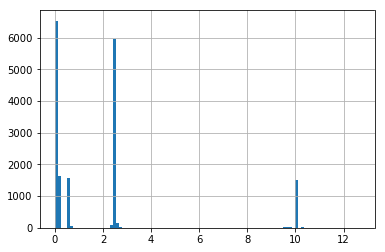

In [15]:
complete_results_df.dose.hist(bins=100)

## Output Processed File

In [16]:
output_file = os.path.join(
    "data",
    "processed",
    "{}_viability_estimates.tsv".format(cell_line_id)
)

complete_results_df.to_csv(output_file, sep='\t', index=False)